## Package prerequisites

In this part, the following libraries need to be imported.

In [110]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mplsoccer import Pitch, VerticalPitch
import seaborn as sns

## Exploratory Data Analysis

First of all, I read a preprocessed (see Part 1 and Part 2) `.csv` data file and convert all required columns to python readable object types. 

In [3]:
# read shots.csv file 
shots = pd.read_csv('.data/shots.csv')
shots.loc[:, 'freeze_frame'] = shots.loc[:, 'freeze_frame'].apply(ast.literal_eval)
shots.loc[:, 'gk_loc'] = shots.loc[:, 'gk_loc'].apply(ast.literal_eval)
shots.loc[:, 'end_loc'] = shots.loc[:, 'end_loc'].apply(ast.literal_eval)

Prediction of a goal outcome in soccer is a binary classification task { 0 - No goal ; 1 - Goal }. However, the key point to note is that, in xG model, we are not dealing with hard classes but rather trying to make a probabilistic prediction for a shot outcome. In comparison with hard classes, probabilistic outputs allow to better understand the quality of shot. In other words,  given a shot, how likely it is to result into a goal. This is what xG value means for a given shot estimates. 

As you can see from below code snippet, there are different outcome types for a given shot such as *Saved*, *Off target*, shot that hit *Post*, *Blocked*, way off target *Wayward* shot and etc. To build a binary probabilistic classifier, it is necessary for us to define predictions as hard classes. Here, I convert each value of `outcome_type` column to 1 for *Goal* scenario or 0 for the rest of scenarios.

In [5]:
shots.loc[:, 'outcome'].unique()

array(['Saved', 'Off T', 'Post', 'Goal', 'Blocked', 'Wayward',
       'Saved Off Target', 'Saved to Post'], dtype=object)

In [22]:
# rename existing 'outcome' column to 'outcome_type' 
shots = shots.rename(columns = {'outcome': 'outcome_type'})
# save binary results into a newly created 'outcome' column
shots.loc[:, 'outcome'] = shots.loc[:, 'outcome_type'].apply(lambda x: 1 if x == 'Goal' else 0)
shots.loc[:, 'outcome']

0        0
1        0
2        0
3        0
4        0
        ..
11038    0
11039    0
11040    0
11041    0
11042    0
Name: outcome, Length: 11043, dtype: int64

Now, let us analyze the types of available shots and their corresponding distribution. From @fig-1 it can be seen that our dataframe has a data on 11043 shots. As we can see below, 1165 of them resulted into a goal.

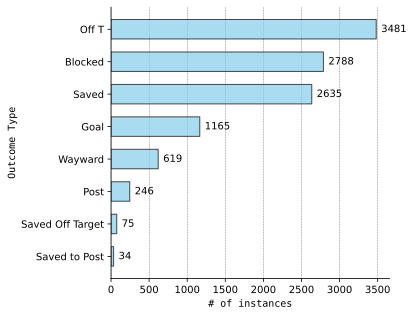

In [106]:
#| label: fig-1 
#| fig-cap: "Distribution of shot outcomes across female soccer competitions."


shot_types = pd.DataFrame(shots.loc[:, 'outcome_type'].value_counts()).reset_index()
shot_types.columns = ['outcome_type', 'n']
shot_types = shot_types.sort_values(by = 'n', ascending = True)

# For LinearSegmented use (no 'colors' attribute):
colors = cm.get_cmap('GnBu', 10)

fig, ax = plt.subplots(figsize = (5, 5))

#ax.grid(visible = False)
ax.grid(color = 'black', ls = '-.', lw = 0.25, axis = "x")
p1 = ax.barh(shot_types["outcome_type"], shot_types["n"], height = 0.6, label = 'n',
       color = 'skyblue', edgecolor = "black", zorder = 2, alpha = 0.7) 

ax.bar_label(p1, padding = 5, label_type='edge')


font = {'family': 'monospace',
        'weight': 'normal',
        'size': 12,
        }

font2 = {'family': 'monospace',
        'weight': 'normal',
        'size': 10,
        }

ax.set_ylabel("Outcome Type", fontdict = font2)
ax.set_xlabel("# of instances", fontdict = font2)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title("", loc = "left", pad = 1, fontdict = font)
ax.spines[['top', 'right']].set_visible(False)


font3 = {'family': 'monospace',
        'weight': 'bold',
        'size': 14
        }

font4 = {'family': 'monospace',
        'style': 'italic',
        'size': 8,
        }

#fig.suptitle('xT per 90 for Ligue 1 Players | 2017/2018 Season', x = 0.1, y = 0.133, fontproperties = font3)


plt.show()

To sum up, we can see that the majority of shots are off target, blocked or saved. Out of 11043 shots, only 1165 are goals. Thus, we can conclude that our data is imbalanced.

Next, we can visualize the location of all shots.

In [134]:
#| label: fig-2
#| fig-cap: "Distribution of shots according to their coordinates."

%config InlineBackend.figure_formats = ['svg']

# Visual shots on Pitch
pitch = Pitch(pitch_type = 'statsbomb')  
fig, ax = pitch.draw(figsize=(6, 8))

sns.scatterplot(data = shots, x = 'x_start', y = 'y_start', ax = ax,
                hue = 'outcome', palette = 'seismic', edgecolor = 'black', alpha = 0.4)

#ax.legend(title = 'Outcome', frameon = False, loc = 'upper left')
#ax.set_title('All shots')

from matplotlib.lines import Line2D

custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='r', linestyle='None')]

plt.legend(custom, ['No Goal', 'Goal'], bbox_to_anchor=(0.05, 0.21))

# Arrow 
arrow_ax = fig.add_axes([0.28, 0.22, 0.35, 0.3]) # X, Y, width, height

arrow_ax.arrow(0.45, 0.1, 0.30, 0, head_width=0.03, head_length=0.03, linewidth=4, 
           color='darkgrey', length_includes_head=True)
arrow_ax.set_ylim(0, 1)
arrow_ax.set_xlim(0, 1)
arrow_ax.set_axis_off()
arrow_ax.annotate('Direction of Play', xy = (0.42, 0.02), fontsize = 10)


plt.show()

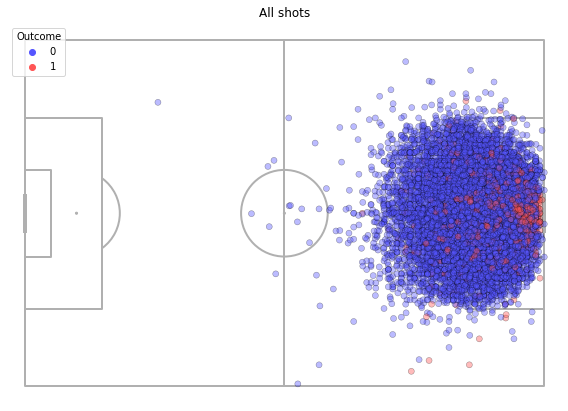

In [6]:
# Visual shots on Pitch
pitch = Pitch(pitch_type = 'statsbomb')  
fig, ax = pitch.draw(figsize=(8, 10))

sns.scatterplot(data = shots, x = 'x_start', y = 'y_start', ax = ax,
                hue = 'outcome', palette = 'seismic', edgecolor = 'black', alpha = 0.4)



#hexmap = pitch.hexbin(shots.x_start, shots.y_start, ax=ax, edgecolors='#f4f4f4', cmap='summer', gridsize = 50)

ax.legend(title = 'Outcome', frameon = True, loc = 'upper left')
ax.set_title('All shots')
plt.show()

**Adding distance and angle features**

In [7]:
# Distance Feature calculation

# define goal center for 'statsbomb'
goal_center = np.array([120, 40])

# calculate distance between shot and goal center
shots['distance'] = np.sqrt((shots['x_start'] - goal_center[0])**2 + (shots['y_start'] - goal_center[1])**2)
shots['distance'] = shots['distance'].round(decimals = 2)

In [8]:
# Angle Feature calculation

# transform x, y coordinates from percentiles to field length coordinates (105 meters x 68 meters)
x = shots['x_start'] * 105/120
y = shots['y_start'] * 68/80 

# Use trigonometric formula to find angle between two sides (a,b ) of triangle where third side (c) 
# is a goal line of length 7.32
a = np.sqrt((x - 105)**2 + (y - 30.34)**2) # length between right post and (x,y) shot coordinate
b = np.sqrt((x - 105)**2 + (y - 37.66)**2) # length between left post and (x,y) shot coordinate
c = 7.32 # goal line length
cos_alpha = (a**2 + b**2 - c**2)/(2*a*b)
cos_alpha = np.round(cos_alpha, decimals = 4)

# remember to leave angle in radians (if you want to transfer to degree multiply cos_alpha by 180/pi)
shots['angle'] = np.arccos(cos_alpha)

In [9]:
shots.head()

,minute,player_name,team_name,play_pattern_name,position_name,under_pressure,x_start,y_start,follows_dribble,first_time,...,outcome_type,end_loc,freeze_frame,gk_loc,gk_loc_x,gk_loc_y,distance_to_gk,outcome,distance,angle
0,7,Lucy Quinn,Tottenham Hotspur Women,Regular Play,Right Wing,0,95.9,58.9,0,0,...,Saved,"[{'end_loc': [116.7, 44.9, 1.2]}]","[{'freeze_frame': [{'location': [119.6, 42.3],...","[119.6, 42.3]",119.6,42.3,28.94,0,30.63,0.220446
1,10,Rianna Dean,Tottenham Hotspur Women,From Free Kick,Center Forward,0,106.1,54.3,0,0,...,Off T,"[{'end_loc': [120.0, 41.6, 4.2]}]","[{'freeze_frame': [{'location': [118.8, 43.2],...","[118.8, 43.2]",118.8,43.2,16.87,0,19.94,0.305489
2,11,Angela Addison,Tottenham Hotspur Women,From Free Kick,Left Wing,1,110.0,28.2,0,0,...,Saved,"[{'end_loc': [117.6, 36.7, 0.4]}]","[{'freeze_frame': [{'location': [111.3, 39.8],...","[118.2, 36.8]",118.2,36.8,11.88,0,15.47,0.372831
3,13,Kit Graham,Tottenham Hotspur Women,From Throw In,Center Attacking Midfield,0,113.2,40.4,0,0,...,Post,"[{'end_loc': [120.0, 37.9, 2.9]}]","[{'freeze_frame': [{'location': [105.8, 46.6],...","[119.3, 39.0]",119.3,39.0,6.26,0,6.81,1.100781
4,16,Kit Graham,Tottenham Hotspur Women,From Counter,Center Attacking Midfield,0,95.2,39.8,0,0,...,Post,"[{'end_loc': [120.0, 37.3, 2.9]}]","[{'freeze_frame': [{'location': [97.8, 49.4], ...","[118.5, 40.0]",118.5,40.0,23.30,0,24.80,0.334118


**Transforming and Splitting Data**

In [24]:
from sklearn.model_selection import train_test_split
# Prepare features and labels from available data
X = shots.loc[:, ['play_pattern_name','under_pressure', 'distance', 'angle', 'gk_loc_x', 'gk_loc_y',
                   'follows_dribble', 'first_time', 'open_goal', 'technique', 'body_part']]
y = shots.loc[:, 'outcome']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

column_trans = ColumnTransformer(
    [('encode_bodyparts', OneHotEncoder(dtype='int'), ['play_pattern_name', 'technique', 'body_part']),
    ('std_coords', StandardScaler(), ['distance', 'angle', 'gk_loc_x', 'gk_loc_y', 'distance_to_gk'])],
    remainder = 'passthrough', verbose_feature_names_out = True)

X_train_trans = column_trans.fit_transform(X_train)

**Logistic Regression | Default Approach**

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss

# Fit Logistic Regression Model
xG_model = LogisticRegression()
xG_model.fit(X_train_trans, y_train)

# evaluate
xG_predictions = xG_model.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7844456393777461

In [27]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = xG_model.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7711598132012787

In [14]:
brier_score_loss(y_valid, xG_predictions)

0.08103146448551397

**Gradient Boosting | Best Performer**

In [28]:
# features used:
# X = shots.loc[:, ['play_pattern_name','under_pressure', 'distance', 'angle', 'gk_loc_x', 'gk_loc_y',
#                   'follows_dribble', 'first_time', 'open_goal', 'technique', 'body_part']]

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.035, loss = 'exponential',
    random_state=0).fit(X_train_trans, y_train)

xG_predictions = clf.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.8534911341713172

In [29]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = clf.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7665505704256252

In [30]:
brier_score_loss(y_valid, xG_predictions)

0.08103410032121545

**MLP | Not enough data to improve performance**

In [31]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, activation = 'tanh', hidden_layer_sizes = (80, 80, 30, 30), alpha = 0.0001, 
#                     learning_rate = 'adaptive', 
                    solver = 'sgd',
                    max_iter = 700).fit(X_train_trans, y_train)

xG_predictions = clf.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7814277147290126

In [32]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = clf.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7698943772331224

In [33]:
brier_score_loss(y_valid, xG_predictions)

0.08177009354960482

**Random Forrest | Performance Close to Gradient Boosting**

In [43]:
from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(max_depth = 10, random_state = 12, criterion = 'entropy')
clf = RandomForestClassifier(max_depth = 10, random_state = 12, criterion = 'entropy')
clf.fit(X_train_trans, y_train)

xG_predictions = clf.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.9201638974766114

In [44]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = clf.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7591675546919076

In [42]:
brier_score_loss(y_valid, xG_predictions)

0.08207883814804616

## Statsmodels

In [1169]:
df_train = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
df_train.head()

,play_pattern_name,under_pressure,distance,angle,gk_loc_x,gk_loc_y,distance_to_gk,follows_dribble,first_time,open_goal,technique,body_part,outcome
0,Regular Play,0,20.10,0.261513,117.5,36.8,16.04,0,0,0,Normal,Right Foot,0
1,From Corner,1,9.11,0.388707,118.9,43.0,5.91,0,0,0,Normal,Head,0
2,Regular Play,0,26.23,0.264971,118.4,37.5,23.49,0,0,0,Normal,Right Foot,0
3,From Throw In,1,25.09,0.259182,118.8,37.3,22.44,0,0,0,Normal,Right Foot,0
4,Regular Play,0,17.80,0.380713,118.0,41.0,15.62,0,0,0,Normal,Left Foot,0


In [1172]:
import statsmodels.formula.api as smf

# run model
logreg_model = smf.logit(
    formula = "outcome ~ distance + angle + under_pressure + gk_loc_y + gk_loc_x + \
    body_part + open_goal + play_pattern_name",
                         data = df_train).fit()

Optimization terminated successfully.
         Current function value: 0.284804
         Iterations 8


In [1173]:
logreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 8834
Model:                          Logit   Df Residuals:                     8816
Method:                           MLE   Df Model:                           17
Date:                Tue, 30 Aug 2022   Pseudo R-squ.:                  0.1512
Time:                        20:54:56   Log-Likelihood:                -2516.0
converged:                       True   LL-Null:                       -2964.3
Covariance Type:            nonrobust   LLR p-value:                1.124e-179
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              13.0536      1.797      7.264      0.000       9.532      16.575
body_part[T.Left Foot]                  0.5300      0.122      4.329      0.000       0.290       0.770
body_part[T.Other]                     -0.5009      0.601     -0.833      0.405      -1.680       0.678
body_part[T.Right Foot]                 0.4744      0.113      4.187      0.000       0.252       0.696
play_pattern_name[T.From Counter]       0.6144      0.185      3.327      0.001       0.253       0.976
play_pattern_name[T.From Free Kick]     0.5234      0.139      3.769      0.000       0.251       0.796
play_pattern_name[T.From Goal Kick]     0.8839      0.207      4.279      0.000       0.479       1.289
play_pattern_name[T.From Keeper]        0.3934      0.352      1.118      0.264      -0.296       1.083
play_pattern_name[T.From Kick Off]      0.2545      0.447      0.569      0.569      -0.622       1.131
play_pattern_name[T.From Throw In]      0.4644      0.132      3.525      0.000       0.206       0.723
play_pattern_name[T.Other]              0.4679      0.510      0.917      0.359      -0.532       1.468
play_pattern_name[T.Regular Play]       0.6333      0.119      5.335      0.000       0.401       0.866
distance                               -0.0920      0.009    -10.024      0.000      -0.110      -0.074
angle                                   1.1505      0.162      7.082      0.000       0.832       1.469
under_pressure                         -0.2136      0.099     -2.148      0.032      -0.408      -0.019
gk_loc_y                                0.0161      0.014      1.169      0.243      -0.011       0.043
gk_loc_x                               -0.1357      0.014     -9.489      0.000      -0.164      -0.108
open_goal                               0.7560      0.243      3.110      0.002       0.280       1.232
=======================================================================================================
"""